In [24]:
%pip install torch
%pip install gym
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym

class DeepQNetwork(nn.Module):
    # 멤버 객체 설정 및 저장
    def __init__(self, lr, state_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(self.state_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    # state를 받아서 각 action에 대한 예상 Q-value를 벡터로 반환 : Q(s)[a]
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        Q_vals_for_each_actions = self.fc3(x)
        return Q_vals_for_each_actions


class DeepQLearningAgent:
    # 멤버 객체 설정 및 저장
    def __init__(self, state_dims=4, n_actions=2, gamma=0.99, epsilon=1.0, lr=0.003, batch_size=64, 
                 mem_size=100000, eps_min=0.01, eps_dec=0.0):
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.state_dims = state_dims
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec

        self.action_space = [i for i in range(n_actions)]
        self.mem_cntr = 0

        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, 
                                   state_dims=state_dims, fc1_dims=16, fc2_dims=16)
        self.state_memory = torch.zeros((self.mem_size, state_dims), dtype=torch.float32)
        self.action_memory = torch.zeros(self.mem_size, dtype=torch.int32)
        self.reward_memory = torch.zeros(self.mem_size, dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.mem_size, state_dims), dtype=torch.float32)
        self.terminal_memory = torch.zeros(self.mem_size, dtype=torch.bool)
    # s, a, r, s'을 history로 기록
    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = done
        self.mem_cntr += 1
    # s를 받아서 DeepQNetwork으로부터 얻은 Q(s)[a]에 따라 greedy action 선택
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space).item()
        else:
            state = state.clone().detach().to(self.Q_eval.device)
            Q_vals_for_each_actions = self.Q_eval.forward(state)
            action = torch.argmax(Q_vals_for_each_actions).item()
        return action
    # learn를 main에서 반복 호출하면 학습이 진행됨
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, size=self.batch_size, replace=False)
        batch_index = torch.arange(self.batch_size, dtype=torch.int32)
        # batch = []
        state_batch = self.state_memory[batch].to(self.Q_eval.device)
        action_batch = self.action_memory[batch].to(self.Q_eval.device)
        reward_batch = self.reward_memory[batch].to(self.Q_eval.device)
        next_state_batch = self.next_state_memory[batch].to(self.Q_eval.device)
        terminal_batch = self.terminal_memory[batch].to(self.Q_eval.device)
        # print(*map(lambda x : x.size(), [state_batch, action_batch, reward_batch, next_state_batch, terminal_batch]))

        # state_batch의 크기: batch_size * state_dim
        # self.Q_eval.forward(state_batch)의 크기: batch_size * n_action
        # action_batch의 크기: batch_size * 1 (0 ~ n_action-1)
        # q의 크기: batch_size * 1
        # 0 1 2 3 / 1 0 0 1
        # [Q(s1)[a1], Q(s2)[a2], ..., Q(sn)[an]] (n=batch_size)
        # q_next=self.Q_eval.forward(next_state_batch)의 크기: batch_size * n_action
        # terminal_batch: [False, False, True, False]
        # torch.max(q_next, dim=1)의 크기: batch_size * n_action
        
        q = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(next_state_batch)
        q_next[terminal_batch, :] = 0.0
        max_q = torch.max(q_next, dim=1)
        q_target = reward_batch + self.gamma * max_q[0]
        loss = self.Q_eval.loss(q_target, q).to(self.Q_eval.device)
        # print(q.size(), q_next.size(), q_target.size(), max_q, loss.size())
        loss.backward()
        self.Q_eval.optimizer.step()
        if self.eps_dec != 0.0:
            self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        else:
            self.epsilon = 5000 / (5000 + self.mem_cntr)

if __name__ == '__main__':
    # OpenAI gym 환경 생성
    env = gym.make('CartPole-v1')
    # 앞서 정의한 Agent 클래스의 객체 생성
    agent = DeepQLearningAgent(state_dims=4, n_actions=2, gamma=0.99, epsilon=1.0, 
                               lr=0.003, batch_size=64, eps_min=0.01)
    # 변수 선언
    score_history, eps_history, avg_score_history = [], [], []
    n_games = 1000

    # 게임을 여러 차례 돌린다
    for i in range(n_games):
        # 변수 선언
        score = 0
        done = False
        state, _ = env.reset()
        state = torch.Tensor(state)
        # 게임 종료 전까지 s, a, r, s' 생성, 학습 및 기록
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, __ = env.step(action)
            next_state = torch.Tensor(next_state)
            score += reward
            if score >= 475:
                break
            agent.store_transition(state, action, reward, next_state, done)
            agent.learn()
            state = next_state
        # 최종 점수 및 epsilon 기록, 평균 점수 기록
        score_history.append(score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)
        # 중요 정보 출력
        print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.4f' % agent.epsilon)
        # Plot learning curve
        x = [i+1 for i in range(n_games)]
        filename = 'CartPole.png'

/Users/jang-yejun/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  0 score 29.00 average score 29.00 epsilon 1.0000
episode  1 score 15.00 average score 22.00 epsilon 1.0000
episode  2 score 62.00 average score 35.33 epsilon 0.9792
episode  3 score 13.00 average score 29.75 epsilon 0.9768
episode  4 score 43.00 average score 32.40 epsilon 0.9686
episode  5 score 9.00 average score 28.50 epsilon 0.9669
episode  6 score 20.00 average score 27.29 epsilon 0.9632
episode  7 score 20.00 average score 26.38 epsilon 0.9595
episode  8 score 29.00 average score 26.67 epsilon 0.9542
episode  9 score 10.00 average score 25.00 epsilon 0.9524
episode  10 score 9.00 average score 23.55 epsilon 0.9508
episode  11 score 10.00 average score 22.42 epsilon 0.9489
episode  12 score 19.00 average score 22.15 epsilon 0.9455
episode  13 score 22.00 average score 22.14 epsilon 0.9416
episode  14 score 34.00 average score 22.93 epsilon 0.9356
episode  15 score 24.00 average score 23.00 epsilon 0.9314
episode  16 score 25.00 average score 23.12 epsilon 0.9271
episode  

KeyboardInterrupt: 

In [26]:
import matplotlib.pyplot as plt

# Learning curve 그리기
def plot_learning_curve(x, score_history, eps_history, avg_score_history, filename, lines=None):
    fig=plt.figure()
    ax1=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    x = [i+1 for i in range(len(score_history))]
    ax1.plot(x, eps_history, color="blue")
    ax2.plot(x, score_history, color="pink")
    ax2.plot(x, avg_score_history, color="red")
    
    ax1.set_xlabel("# episodes", color="black")
    ax1.set_ylabel("Epsilons / scores", color="black")
    ax1.tick_params(axis='x', colors="black")
    ax1.tick_params(axis='y', colors="black")

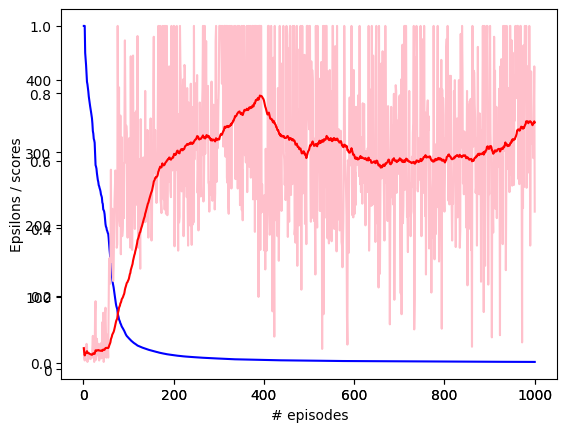

In [27]:
plot_learning_curve(x, score_history, eps_history, avg_score_history, filename)